### 사용한 TabNet 라이브러리는 [PyTorch-TabNet](https://github.com/dreamquark-ai/tabnet) 으로 scikit-learn 인터페이스를 따르고 있음.

# Import

In [1]:
#import data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_row', 50)

SEED = 42
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(SEED)

# Load data and split

In [4]:
path = 'data/'

train = pd.read_csv(path+'mod_train_rating_5n.csv')
test = pd.read_csv(path+'mod_test_rating_5n.csv')

print(train.shape)
print(test.shape)

(306795, 10)
(76699, 10)


In [5]:
train.head()

,user_id,isbn,rating,book_author,publisher,language,category_high,years,fix_location_state,fix_age
0,8.0,0002005018,4.0,Richard Bruce Wright,Flamingo,en,actresses,2020,ontario,10
1,8.0,074322678X,4.0,Ann Beattie,Scribner,en,fiction,2020,ontario,10
2,8.0,0887841740,2.0,Sheila Heti,House of Anansi Press,en,fiction,2020,ontario,10
3,8.0,1552041778,2.0,R. J. Kaiser,Mira,en,fiction,2000,ontario,10
4,8.0,1567407781,6.0,Loren D. Estleman,Brilliance Audio,en,fiction,2000,ontario,10


<AxesSubplot:>

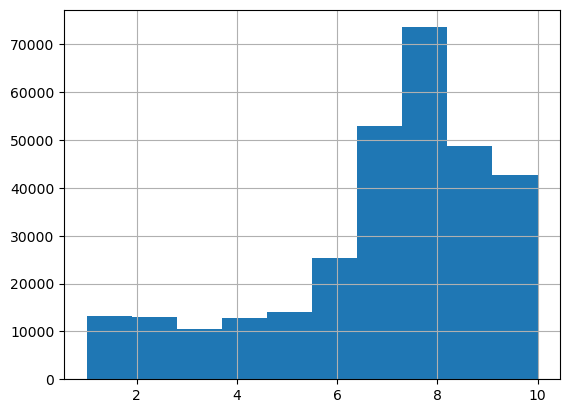

In [6]:
train['rating'].hist()

# KSY process

In [ ]:
tem = train['user_id'].value_counts()
tem = list(tem[tem >= 10].index)
train['id'] = train['user_id'].copy()
train['id'][~train['id'].isin(tem)] = -1
test['id'] = test['user_id'].copy()
test['id'][~test['id'].isin(tem)] = -1

In [ ]:
tem = train['isbn'].value_counts()
tem = list(tem[tem >= 10].index)
train['bn'] = train['isbn'].copy()
train['bn'][~train['bn'].isin(tem)] = 1000000000
test['bn'] = test['isbn'].copy()
test['bn'][~test['bn'].isin(tem)] = 1000000000

In [ ]:
train['years'] = train['years'].astype('str')
train['fix_age'] = train['fix_age'].astype('str')
train['id'] = train['id'].astype('str')
train['bn'] = train['bn'].astype('str')

test['years'] = test['years'].astype('str')
test['fix_age'] = test['fix_age'].astype('str')
test['id'] = test['id'].astype('str')
test['bn'] = test['bn'].astype('str')

In [ ]:
train.head()

In [ ]:
target = 'rating'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid"], p =[.9, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index

test["Set"] = 'test'
test_indices = test.index

In [ ]:
print(train_indices)

# Simple preprocessing

In [ ]:
train.dtypes

In [ ]:
train.head()

In [ ]:
# Label encode categorical features and fill empty cells.
from sklearn.preprocessing import LabelEncoder

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if train.dtypes[col] == 'object' or train.nunique()[col] < 100:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely") # 결측값 채우기, 얘는 뭐지?
        train[col] = l_enc.fit_transform(train[col].values) # 정수값으로 인코딩(수치화)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)    # numerical 결측값 평균으로 채우기

print("========================================================")

for col in test.columns:
    if test.dtypes[col] == 'object' or test.nunique()[col] < 100:
        print(col, test[col].nunique())
        l_enc = LabelEncoder()
        test[col] = test[col].fillna("VV_likely")
        test[col] = l_enc.fit_transform(test[col].values)
    else:
        test.fillna(test.loc[test_indices, col].mean(), inplace=True)

# object 타입 or nunique < 200인 변수들을 인코딩해서 카테고리컬 변수로 넣어주기

# Define categorical features for categorical embeddings

In [ ]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [ ]:
cat_dims

In [ ]:
# define your embedding sizes : here just a random choice (default =1)
# cat_idxs나 cat_dims와 동일한 형태로 만들어야함 or int
# cat_emb_dim = [10, 10, 10, 10, 10, 10, 10, 10]

# Network parameters

In [ ]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

clf = TabNetRegressor(  cat_idxs=cat_idxs,
                        cat_dims=cat_dims,
                        cat_emb_dim=10,
                        optimizer_fn=torch.optim.Adam,  # (default=torch.optim.Adam)
                        optimizer_params=dict(lr=2e-2), # (default=dict(lr=2e-2))
                        scheduler_params={"step_size":10,
                                            "gamma":0.95},
                        scheduler_fn=torch.optim.lr_scheduler.StepLR,   # (default=None)
                        mask_type='entmax', # "sparsemax", entmax
                        n_steps=5  # (default=3) 이게 부스팅 단계 조절 파라미터! 보통 3~10 정도 사용한대
                        )

In [ ]:
print(features)

In [ ]:
train.head()

# Training

In [ ]:
# X와 y의 형태 맞춰주기 -> n_tragets 값은 변경 가능
n_targets = 1

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]
y_train = np.transpose(np.tile(y_train, (n_targets,1)))

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]
y_valid = np.transpose(np.tile(y_valid, (n_targets,1)))

X_test = test[features].values[test_indices]
y_test = test[target].values[test_indices]
y_test = np.transpose(np.tile(y_test, (n_targets,1)))

In [ ]:
print(X_train.shape, y_train.shape)

In [ ]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

In [ ]:
from torch import nn

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmse'], #['rmsle', 'mae', 'rmse', 'mse']
    max_epochs=max_epochs,
    patience=10,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=True, # (default=False)
)

# default loss_fn: mse

In [ ]:
print(f"BEST VALID SCORE FOR bookrec - best epoch {clf.best_epoch}: {clf.best_cost}")

# Test

In [ ]:
preds = clf.predict(X_test)

In [ ]:
preds

# Submit

In [ ]:
submit = pd.read_csv(path+'sample_submission.csv')

In [ ]:
submit['rating'] = preds

In [ ]:
submit

In [ ]:
import time

now = time.localtime()
now_date = time.strftime('%Y%m%d', now)
now_hour = time.strftime('%X', now)
save_time = now_date + '_' + now_hour.replace(':', '')

submit.to_csv('submit/KCH_{}_TabNet_{}{}_{}epoch_{:.4f}.csv'.format(save_time, clf.mask_type, clf.n_steps, clf.best_epoch, clf.best_cost, index = False))

# Global explainability : feat importance summing to 1

In [ ]:
clf.feature_importances_

# Local explainability and masks

In [ ]:
explain_matrix, masks = clf.explain(X_test)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
fig, axs = plt.subplots(1, clf.n_steps, figsize=(20,20))

for i in range(clf.n_steps):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [ ]:
explain_matrix.shape

In [ ]:
masks.keys()

In [ ]:
submit['rating'].hist()

# Model Save / Load

In [ ]:
# 예제 코드를 그냥 가져온 것으로 조금 수정이 필요할 듯
"""
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)
"""